# 12_nndl_cv_mlp2

We will experiment with Neural Networks and Deep Learning on the no_na dataset. This is mlp2, our second version of multi-layer perceptron 

# Difference from mlp1 - no dropout on the input layer

In [1]:
''' data and math '''
import pandas as pd
import numpy as np

''' plotting images '''
from matplotlib import pyplot as plt
%matplotlib inline

''' traversing directories '''
import os
from pathlib import Path

''' utilities '''
from tqdm import tqdm

''' metrics '''
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

''' preprocessing '''
from sklearn.preprocessing import StandardScaler

In [2]:
''' used to reference the root directory, for directory traversal ''' 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = Path('/content/gdrive/My Drive/it3011_project')

Mounted at /content/gdrive


# Loading data

In [3]:
# load data
train = pd.read_csv(root_dir/"data/train_no_na.csv")
test = pd.read_csv(root_dir/"data/test_no_na.csv")
print("data loaded")

data loaded


In [4]:
# check shape
print(train.shape)
print(test.shape)

(279331, 138)
(120163, 138)


In [5]:
# create train/test sets
features = [feature for feature in test.keys() if "feature" in feature]
x_train = train.loc[:, features].values
y_train = train.loc[:,['action']].values.flatten()
x_test = test.loc[:, features].values
y_test = test.loc[:,['action']].values.flatten()
print("train/test set created")

train/test set created


# Helper functions

In [6]:
# constants
SEED = 42

# cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=SEED, shuffle=True)

In [7]:
# create the utility score, which takes in the prediction value and the ground truth action and generates a score
# link: https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation

# data: original train/test data    action: the y-value. can either be y_pred or original values too, if we want the max score attainable
def utility_score(data, action): 
  dates_set = set(data.date.values)
  dates = data.loc[:, ['date']].values.flatten()
  weights = data.loc[:, ['weight']].values.flatten()
  resps = data.loc[:, ['resp']].values.flatten()
  actions = action.flatten()

  i = len(dates_set)
  p_i = []

  for date in dates_set:
    indices = np.where(dates == date)[0]
    p_i_temp = 0
    for j in indices:
      p_i_temp = p_i_temp + weights[j] * resps[j] * actions[j]
    p_i.append(p_i_temp)
  
  p_i_squared = [p_i1*p_i2 for p_i1,p_i2 in zip(p_i,p_i)]
  t = ( sum(p_i) / np.sqrt(sum(p_i_squared)) ) * np.sqrt(250/i)
  u = min(max(t, 0), 6) * sum(p_i)

  return u

def max_train_utility_score(data=train, action=y_train):
  return utility_score(data, action)

def max_test_utility_score(data=test, action=y_test):
  return utility_score(data, action)

In [8]:
def model_scores(model, test, x_test, y_test):
  y_pred = model.predict(x_test) 
  y_pred = (y_pred > 0.5).astype(int)
  
  # # get some scores from helpers
  utility = utility_score(test, y_pred)
  accuracy =  accuracy_score(y_test, y_pred)

  # # confusion matrix
  # print("confusion matrix")
  cm = confusion_matrix(y_test, y_pred)
  true_pos = cm[1][1]
  true_neg = cm[0][0]
  false_pos = cm[0][1]
  false_neg = cm[1][0]

  # # plot confusion matrix
  # fig, ax = plt.subplots(figsize=(3, 3))
  # ax.imshow(cm)
  # ax.grid(False)
  # ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
  # ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
  # ax.set_ylim(1.5, -0.5)
  # for i in range(2):
  #     for j in range(2):
  #         ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
  # plt.show()  

  # # AUC-ROC
  # print("AUC_ROC")
  logit_roc_auc = roc_auc_score(y_test, y_pred)

  # # plot auc-roc
  # fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
  # plt.figure()
  # plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  # plt.plot([0, 1], [0, 1],'r--')
  # plt.xlim([0.0, 1.0])
  # plt.ylim([0.0, 1.05])
  # plt.xlabel('False Positive Rate')
  # plt.ylabel('True Positive Rate')
  # plt.title('Receiver operating characteristic')
  # plt.legend(loc="lower right")
  # plt.show()

  return utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg

In [9]:
import datetime
import csv

def save_scores(output_filename, workbook_name, model_name, model_params, utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg):
  # create output file if not exists
  try:
    f = open(root_dir/output_filename)
  except IOError:
    with open (root_dir/output_filename, 'a') as csvfile:
      headers = ["workbook_name", "model_name", "model_params", "utility", "accuracy", "logit_roc_auc", "true_pos", "true_neg", "false_pos", "false_neg", "timestamp"]
      writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n',fieldnames=headers)
      writer.writeheader() 
      print("created output file")  
    csvfile.close()

  # output file exists, append
  timestamp = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
  
  ''' create another df that looks just like the excel file and concat with ''' 
  new_scores = pd.DataFrame(np.array([[workbook_name, model_name, model_params, utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg, timestamp]]),
                   columns=["workbook_name", "model_name", "model_params", "utility", "accuracy", "logit_roc_auc", "true_pos", "true_neg", "false_pos", "false_neg", "timestamp"],
                  )

  new_scores.to_csv(root_dir/output_filename, mode='a', header=False, index=False)
  print("saved model metrics")

In [10]:
'''
used to generate the PosixPath variables for the results to save
'''
def results_paths(root_dir=root_dir):
    PATH_RESULTS = root_dir /'results_nndl'
    PATH_HISTORIES = PATH_RESULTS / 'histories'
    PATH_FIGURES = PATH_RESULTS / 'figures'
    PATH_CHECKPOINTS = PATH_RESULTS / 'checkpoints'
    PATH_PREDICTIONS = PATH_RESULTS / 'predictions'

    return PATH_RESULTS, PATH_HISTORIES, PATH_FIGURES, PATH_CHECKPOINTS, PATH_PREDICTIONS


''' 
used to save the history of a model as a npy file
'''
# filename like 'history/model_name.npy'
def history_saver(history, model_name, history_save_path, already_npy=False):
  history_json = {}

  if already_npy:
    history_npy = history
  else:
    history_npy = history.history

  np.save(history_save_path/model_name, history_npy)
  print("History saved")



''' 
used to load the history of a model from a npy file
'''
# filename like 'history/model_name.npy'
def history_loader(model_name, history_save_path):
  history_save_path = history_save_path/str(model_name+'.npy')
  history=np.load(history_save_path,allow_pickle='TRUE').item()
  print('History loaded')
  
  return history 

'''
used to plot the metrics for a given history
'''
def plot_metrics(history, model_name, figure_save_path):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # print(history.keys())

    # plot losses
    train_loss = history['loss']
    val_loss = history['val_loss']
    loss_title = 'loss against epochs'

    ax1.plot(train_loss, label='train')
    ax1.plot(val_loss, label='val')
    ax1.set_title(loss_title)
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epochs')
    ax1.legend()

    # plot accuracy_score
    accuracy_score = history['accuracy']
    val_accuracy_score = history['val_accuracy']
    accuracy_score_title = 'accuracy_score against epochs'

    ax2.plot(accuracy_score, label='train')
    ax2.plot(val_accuracy_score, label='val')
    ax2.set_title(accuracy_score_title)
    ax2.set_ylabel('accuracy_score')
    ax2.set_xlabel('epochs')
    ax2.legend()


    # plot accuracy_score
    auc_score = history['auc']
    val_auc_score = history['val_auc']
    auc_score_title = 'auc_score against epochs'

    ax3.plot(auc_score, label='train')
    ax3.plot(val_auc_score, label='val')
    ax3.set_title(auc_score_title)
    ax3.set_ylabel('auc_score')
    ax3.set_xlabel('epochs')
    ax3.legend()


    # save figure
    fig.suptitle('Metrics for model: ' + model_name)
    plt.savefig(figure_save_path/f'{model_name}.png')

    plt.show()  

# Neural Network - Model 2 (Activations)

In [11]:
!pip install keras_tqdm

In [12]:
import tensorflow as tf
import tensorflow.keras as keras

from keras_tqdm import TQDMCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import BinaryAccuracy, AUC

tf.random.set_seed(SEED)
np.random.seed(SEED)

In [13]:
PATH_RESULTS, PATH_HISTORIES, PATH_FIGURES, PATH_CHECKPOINTS, PATH_PREDICTIONS = results_paths()

In [14]:
def create_mlp(num_columns, hidden_units, activation, dropout_rates, learning_rate): 
  inp = Input(shape=(num_columns,))
  x = BatchNormalization()(inp)

  for i in range(len(hidden_units)):   
    x = Dense(hidden_units[i])(x)
    x = Activation(activation)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rates[i])(x)

  x = Dense(1)(x)
  out = Activation("sigmoid")(x)

  model = Model(inputs=inp, outputs=out)

  model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=BinaryCrossentropy(label_smoothing=1e-4),
    metrics=[BinaryAccuracy(name="accuracy"), AUC(name="auc")]
  )

  return model

In [15]:
# settings to vary

# epochs default = [50] going forward for training due to time constraints, final evaluation put about 1000 to try and achieve convergence
epochs = [50] 

# batch_sizes default = [512] going forward for training due to time constraints, final evaluation can be batch size of 128/256 to achieve better utility scores
batch_sizes = [512]

# hidden_units default = [200, 400, 800, 400] going forward for training due to time constraints, final evaluation can be greater number of hidden units to achieve better utility scores
hidden_units = [
    [200, 400, 800, 400]
]

# dropout_rates should have same number of values as hidden_units
# dropout_rates default = [0.2, 0.2, 0.2, 0.2] going forward for training due to very poor performance of 0.4, and 0 provides no regularizing effect (model has not converged yet)
dropout_rates = [
    [0.2, 0.2, 0.2, 0.2]
] 

# activations default = [tf.keras.activations.tanh] going forward for training due to it performing well
activations = [tf.keras.activations.tanh]

# learning_rates default = [1e-4]
learning_rates = [1e-2, 1e-4, 1e-6]


model_name:  mlp2_learning_rates_0.01
model_params:  batch_size=512, hidden_unit=[200, 400, 800, 400], activation=<function tanh at 0x7fc3beb8e680>, dropout_rate=[0.2, 0.2, 0.2, 0.2], learning_rate=0.01, epoch=50
training model fold 1
Epoch 1/50
492/492 [==============================] - 11s 15ms/step - loss: 0.8190 - accuracy: 0.5023 - auc: 0.5022 - val_loss: 0.8937 - val_accuracy: 0.4812 - val_auc: 0.4829
Epoch 2/50
492/492 [==============================] - 6s 13ms/step - loss: 0.7109 - accuracy: 0.5028 - auc: 0.5032 - val_loss: 0.6946 - val_accuracy: 0.4828 - val_auc: 0.4879
Epoch 3/50
492/492 [==============================] - 6s 12ms/step - loss: 0.6963 - accuracy: 0.5071 - auc: 0.5085 - val_loss: 0.7195 - val_accuracy: 0.5107 - val_auc: 0.5080
Epoch 4/50
492/492 [==============================] - 6s 13ms/step - loss: 0.6972 - accuracy: 0.5059 - auc: 0.5069 - val_loss: 0.6918 - val_accuracy: 0.5243 - val_auc: 0.5183
Epoch 5/50
492/492 [==============================] - 6s 12ms/s

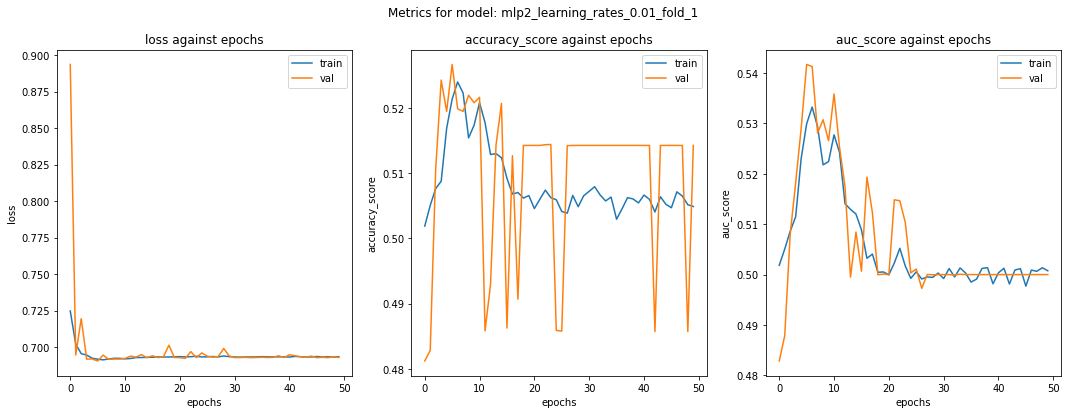

training model fold 2
Epoch 1/50
492/492 [==============================] - 9s 14ms/step - loss: 0.9335 - accuracy: 0.5063 - auc: 0.5056 - val_loss: 0.7165 - val_accuracy: 0.4919 - val_auc: 0.5009
Epoch 2/50
492/492 [==============================] - 7s 14ms/step - loss: 0.7032 - accuracy: 0.5043 - auc: 0.5059 - val_loss: 0.7280 - val_accuracy: 0.5077 - val_auc: 0.5175
Epoch 3/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6988 - accuracy: 0.5104 - auc: 0.5132 - val_loss: 0.7019 - val_accuracy: 0.5140 - val_auc: 0.5149
Epoch 4/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6948 - accuracy: 0.5140 - auc: 0.5189 - val_loss: 0.6913 - val_accuracy: 0.5239 - val_auc: 0.5332
Epoch 5/50
492/492 [==============================] - 7s 13ms/step - loss: 0.6918 - accuracy: 0.5222 - auc: 0.5299 - val_loss: 0.6908 - val_accuracy: 0.5295 - val_auc: 0.5409
Epoch 6/50
492/492 [==============================] - 7s 13ms/step - loss: 0.6914 - accuracy: 0.5224 - 

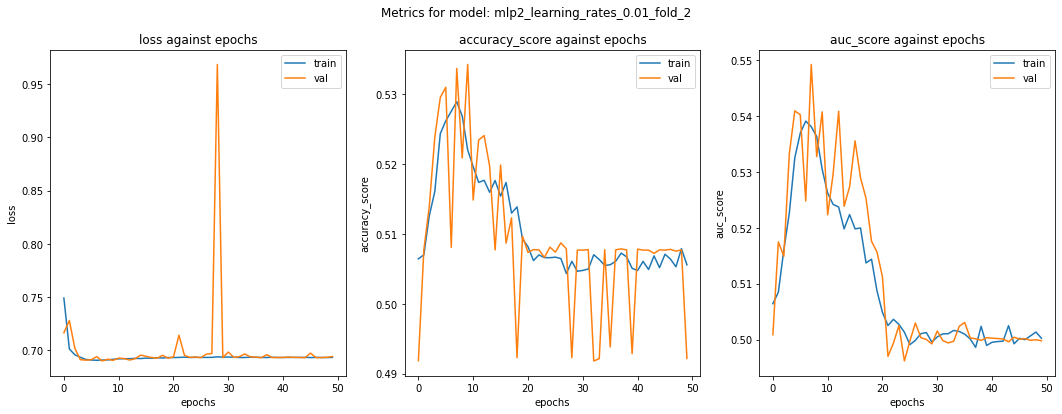

training model fold 3
Epoch 1/50
492/492 [==============================] - 9s 15ms/step - loss: 0.9396 - accuracy: 0.5011 - auc: 0.5001 - val_loss: 0.8908 - val_accuracy: 0.5088 - val_auc: 0.5082
Epoch 2/50
492/492 [==============================] - 7s 14ms/step - loss: 0.7171 - accuracy: 0.5038 - auc: 0.5028 - val_loss: 0.7187 - val_accuracy: 0.4943 - val_auc: 0.4935
Epoch 3/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6986 - accuracy: 0.5022 - auc: 0.5015 - val_loss: 0.6982 - val_accuracy: 0.5101 - val_auc: 0.5104
Epoch 4/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6970 - accuracy: 0.5039 - auc: 0.5037 - val_loss: 0.7002 - val_accuracy: 0.5050 - val_auc: 0.5051
Epoch 5/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6946 - accuracy: 0.5173 - auc: 0.5211 - val_loss: 0.6935 - val_accuracy: 0.5252 - val_auc: 0.5288
Epoch 6/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6915 - accuracy: 0.5274 - 

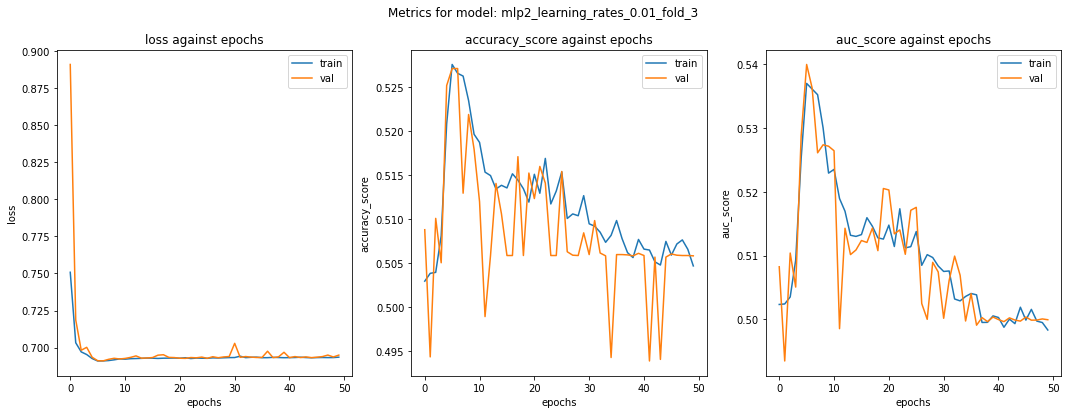

training model fold 4
Epoch 1/50
492/492 [==============================] - 9s 15ms/step - loss: 1.1079 - accuracy: 0.5038 - auc: 0.5031 - val_loss: 0.6965 - val_accuracy: 0.4927 - val_auc: 0.5030
Epoch 2/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6996 - accuracy: 0.5035 - auc: 0.5012 - val_loss: 0.6943 - val_accuracy: 0.4911 - val_auc: 0.4920
Epoch 3/50
492/492 [==============================] - 7s 14ms/step - loss: 0.7007 - accuracy: 0.5043 - auc: 0.5051 - val_loss: 0.7215 - val_accuracy: 0.4980 - val_auc: 0.5092
Epoch 4/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6991 - accuracy: 0.5077 - auc: 0.5080 - val_loss: 0.6998 - val_accuracy: 0.5014 - val_auc: 0.5046
Epoch 5/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6950 - accuracy: 0.5099 - auc: 0.5099 - val_loss: 0.6954 - val_accuracy: 0.5137 - val_auc: 0.5228
Epoch 6/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6937 - accuracy: 0.5161 - 

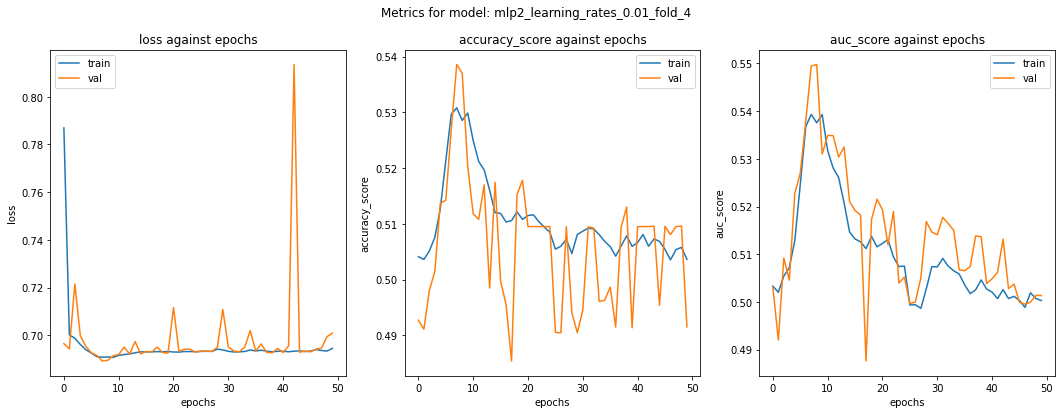

training model fold 5
Epoch 1/50
492/492 [==============================] - 10s 15ms/step - loss: 1.0462 - accuracy: 0.5019 - auc: 0.5007 - val_loss: 0.8688 - val_accuracy: 0.5155 - val_auc: 0.5159
Epoch 2/50
492/492 [==============================] - 7s 14ms/step - loss: 0.7089 - accuracy: 0.5065 - auc: 0.5076 - val_loss: 0.8065 - val_accuracy: 0.5140 - val_auc: 0.5256
Epoch 3/50
492/492 [==============================] - 7s 14ms/step - loss: 0.7053 - accuracy: 0.5108 - auc: 0.5123 - val_loss: 0.7160 - val_accuracy: 0.5165 - val_auc: 0.5317
Epoch 4/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6974 - accuracy: 0.5132 - auc: 0.5166 - val_loss: 0.7057 - val_accuracy: 0.4925 - val_auc: 0.5052
Epoch 5/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6953 - accuracy: 0.5120 - auc: 0.5161 - val_loss: 0.6958 - val_accuracy: 0.5104 - val_auc: 0.5209
Epoch 6/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6931 - accuracy: 0.5173 -

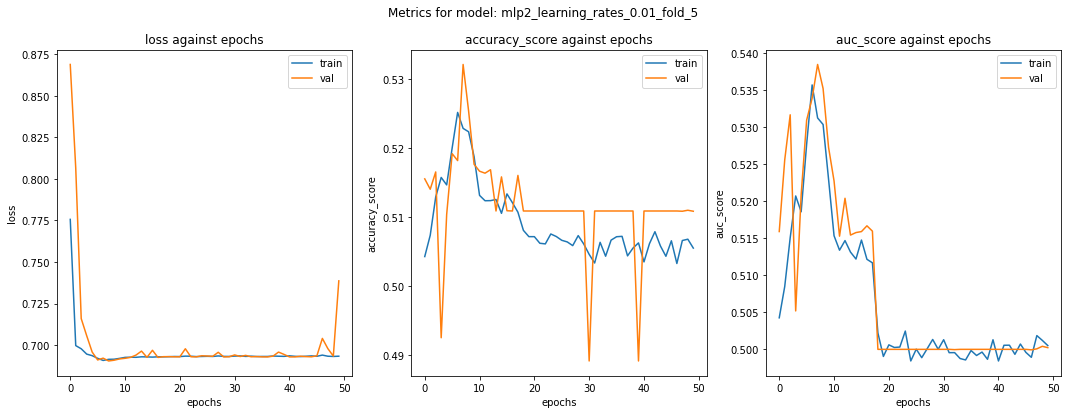

training model fold 6
Epoch 1/50
492/492 [==============================] - 10s 16ms/step - loss: 1.0668 - accuracy: 0.5028 - auc: 0.5026 - val_loss: 0.6959 - val_accuracy: 0.4955 - val_auc: 0.4949
Epoch 2/50
492/492 [==============================] - 7s 15ms/step - loss: 0.6997 - accuracy: 0.5052 - auc: 0.5054 - val_loss: 0.6926 - val_accuracy: 0.5122 - val_auc: 0.5147
Epoch 3/50
492/492 [==============================] - 7s 15ms/step - loss: 0.6996 - accuracy: 0.5051 - auc: 0.5060 - val_loss: 0.7288 - val_accuracy: 0.4987 - val_auc: 0.5107
Epoch 4/50
492/492 [==============================] - 7s 15ms/step - loss: 0.6985 - accuracy: 0.5070 - auc: 0.5083 - val_loss: 0.7256 - val_accuracy: 0.5067 - val_auc: 0.4998
Epoch 5/50
492/492 [==============================] - 7s 15ms/step - loss: 0.6987 - accuracy: 0.5077 - auc: 0.5105 - val_loss: 0.6971 - val_accuracy: 0.5056 - val_auc: 0.5035
Epoch 6/50
492/492 [==============================] - 7s 15ms/step - loss: 0.6940 - accuracy: 0.5141 -

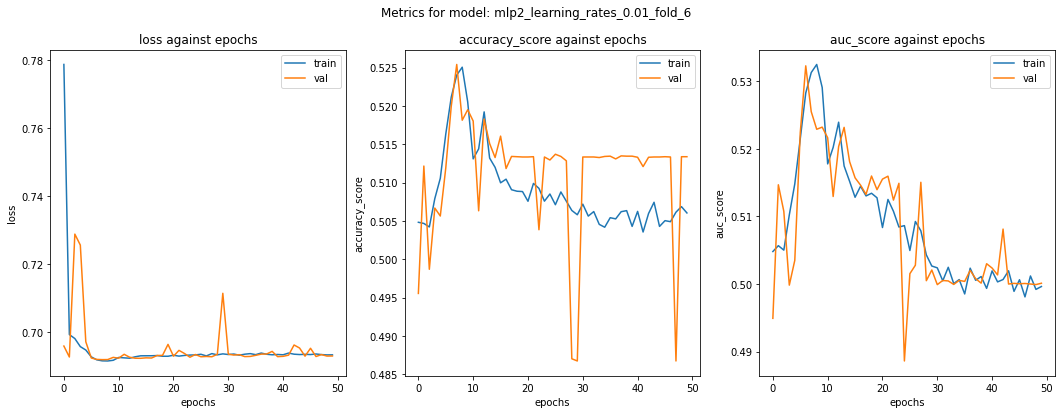

training model fold 7
Epoch 1/50
492/492 [==============================] - 10s 16ms/step - loss: 0.9786 - accuracy: 0.5018 - auc: 0.5012 - val_loss: 0.7403 - val_accuracy: 0.5041 - val_auc: 0.5044
Epoch 2/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7035 - accuracy: 0.5045 - auc: 0.5052 - val_loss: 0.6935 - val_accuracy: 0.5185 - val_auc: 0.5209
Epoch 3/50
492/492 [==============================] - 7s 15ms/step - loss: 0.6985 - accuracy: 0.5087 - auc: 0.5085 - val_loss: 0.6949 - val_accuracy: 0.5036 - val_auc: 0.5139
Epoch 4/50
492/492 [==============================] - 7s 15ms/step - loss: 0.6951 - accuracy: 0.5160 - auc: 0.5193 - val_loss: 0.6915 - val_accuracy: 0.5234 - val_auc: 0.5344
Epoch 5/50
492/492 [==============================] - 7s 15ms/step - loss: 0.6933 - accuracy: 0.5218 - auc: 0.5290 - val_loss: 0.6923 - val_accuracy: 0.5247 - val_auc: 0.5355
Epoch 6/50
492/492 [==============================] - 7s 15ms/step - loss: 0.6911 - accuracy: 0.5276 -

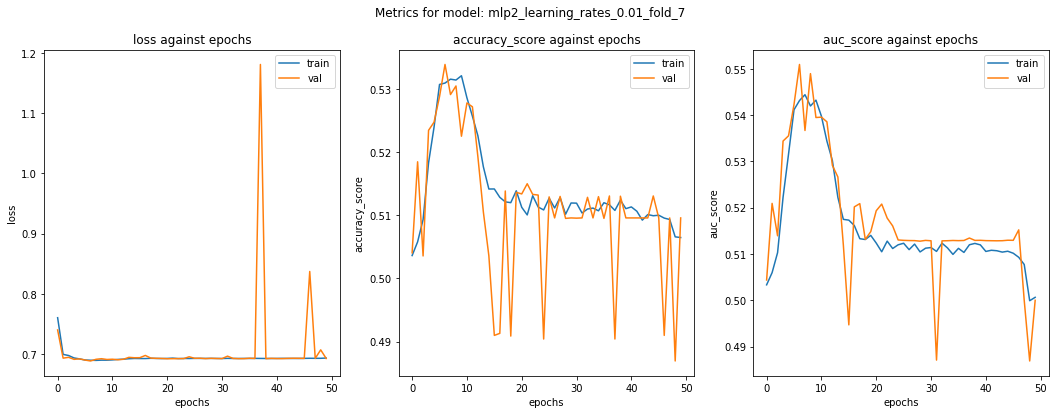

training model fold 8
Epoch 1/50
492/492 [==============================] - 10s 16ms/step - loss: 0.9786 - accuracy: 0.4989 - auc: 0.4988 - val_loss: 0.7205 - val_accuracy: 0.4989 - val_auc: 0.5017
Epoch 2/50
492/492 [==============================] - 7s 15ms/step - loss: 0.7019 - accuracy: 0.5031 - auc: 0.5025 - val_loss: 0.6953 - val_accuracy: 0.5081 - val_auc: 0.5150
Epoch 3/50
492/492 [==============================] - 7s 15ms/step - loss: 0.6994 - accuracy: 0.5043 - auc: 0.5047 - val_loss: 0.7570 - val_accuracy: 0.4982 - val_auc: 0.5033
Epoch 4/50
492/492 [==============================] - 7s 15ms/step - loss: 0.7015 - accuracy: 0.5143 - auc: 0.5181 - val_loss: 0.6939 - val_accuracy: 0.5080 - val_auc: 0.5211
Epoch 5/50
492/492 [==============================] - 8s 15ms/step - loss: 0.6928 - accuracy: 0.5185 - auc: 0.5238 - val_loss: 0.6933 - val_accuracy: 0.5081 - val_auc: 0.5216
Epoch 6/50
492/492 [==============================] - 7s 15ms/step - loss: 0.6923 - accuracy: 0.5202 -

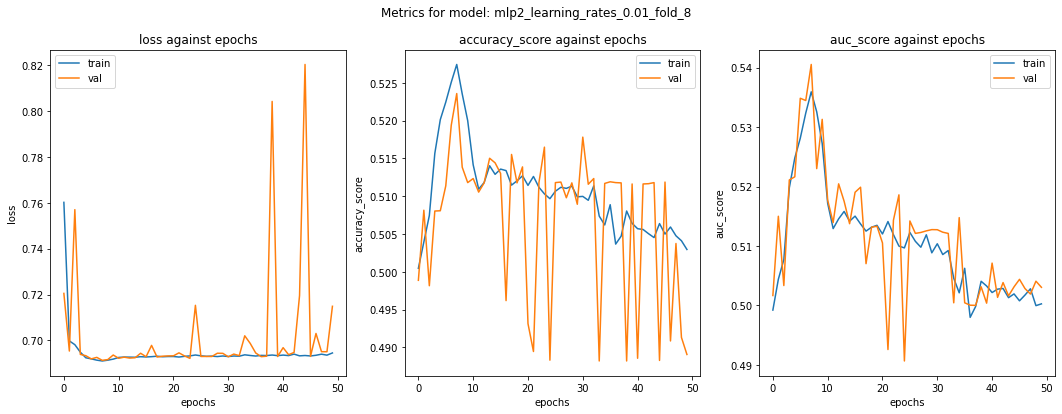

training model fold 9
Epoch 1/50
492/492 [==============================] - 10s 16ms/step - loss: 0.9031 - accuracy: 0.5032 - auc: 0.5020 - val_loss: 0.8072 - val_accuracy: 0.4960 - val_auc: 0.4958
Epoch 2/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7114 - accuracy: 0.5033 - auc: 0.5040 - val_loss: 0.7080 - val_accuracy: 0.4906 - val_auc: 0.4982
Epoch 3/50
492/492 [==============================] - 7s 15ms/step - loss: 0.7022 - accuracy: 0.5075 - auc: 0.5073 - val_loss: 0.6970 - val_accuracy: 0.5129 - val_auc: 0.5272
Epoch 4/50
492/492 [==============================] - 8s 15ms/step - loss: 0.6948 - accuracy: 0.5119 - auc: 0.5136 - val_loss: 0.7069 - val_accuracy: 0.4860 - val_auc: 0.4965
Epoch 5/50
492/492 [==============================] - 8s 16ms/step - loss: 0.6955 - accuracy: 0.5158 - auc: 0.5171 - val_loss: 0.6925 - val_accuracy: 0.5149 - val_auc: 0.5304
Epoch 6/50
492/492 [==============================] - 7s 15ms/step - loss: 0.6920 - accuracy: 0.5220 -

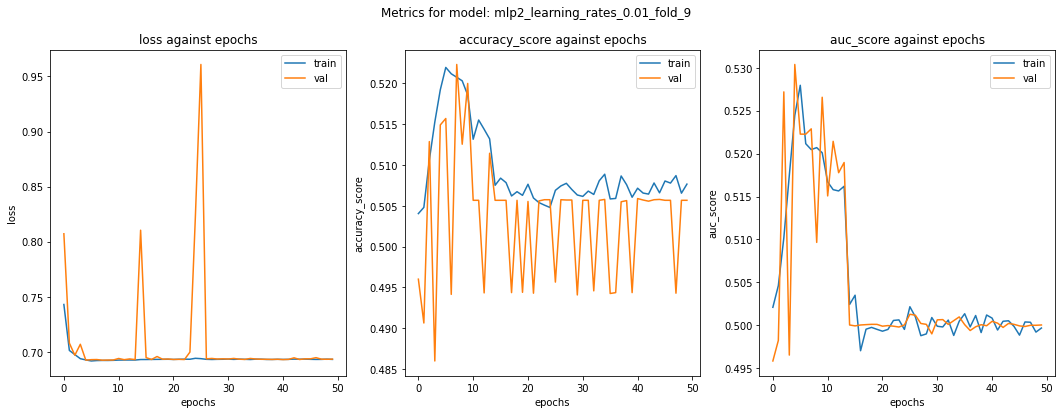

training model fold 10
Epoch 1/50
492/492 [==============================] - 10s 16ms/step - loss: 1.0019 - accuracy: 0.5012 - auc: 0.5006 - val_loss: 0.7698 - val_accuracy: 0.5098 - val_auc: 0.5116
Epoch 2/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7015 - accuracy: 0.5022 - auc: 0.5029 - val_loss: 0.7465 - val_accuracy: 0.5066 - val_auc: 0.5128
Epoch 3/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7022 - accuracy: 0.5040 - auc: 0.5021 - val_loss: 0.7770 - val_accuracy: 0.5110 - val_auc: 0.5180
Epoch 4/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7034 - accuracy: 0.5085 - auc: 0.5091 - val_loss: 0.6922 - val_accuracy: 0.5232 - val_auc: 0.5213
Epoch 5/50
492/492 [==============================] - 8s 15ms/step - loss: 0.6937 - accuracy: 0.5135 - auc: 0.5173 - val_loss: 0.6916 - val_accuracy: 0.5220 - val_auc: 0.5313
Epoch 6/50
492/492 [==============================] - 8s 15ms/step - loss: 0.6916 - accuracy: 0.5259 

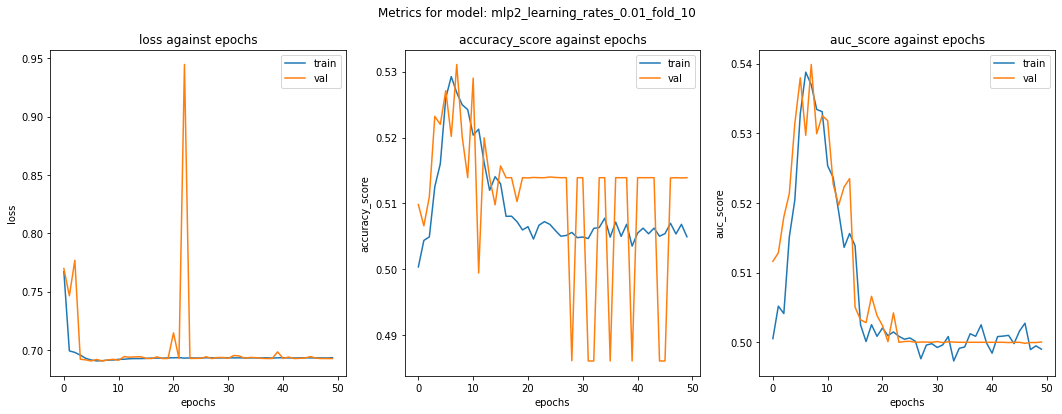

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [10.688525096615558, 0.5046235123915489, 0.5001513869064709, 9995.3, 4100.4, 9579.8, 4257.6]
saved model metrics

model_name:  mlp2_learning_rates_0.0001
model_params:  batch_size=512, hidden_unit=[200, 400, 800, 400], activation=<function tanh at 0x7fc3beb8e680>, dropout_rate=[0.2, 0.2, 0.2, 0.2], learning_rate=0.0001, epoch=50
training model fold 1
Epoch 1/50
492/492 [==============================] - 10s 17ms/step - loss: 0.8032 - accuracy: 0.5063 - auc: 0.5077 - val_loss: 0.7029 - val_accuracy: 0.5270 - val_auc: 0.5373
Epoch 2/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7484 - accuracy: 0.5127 - auc: 0.5170 - val_loss: 0.6945 - val_accuracy: 0.5354 - val_auc: 0.5518
Epoch 3/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7332 - accuracy: 0.5173 - auc: 0.5221 - val_loss: 0.6896 - val_accuracy: 0.5455 - val_auc: 0.5651
Epoch 4/50
492/

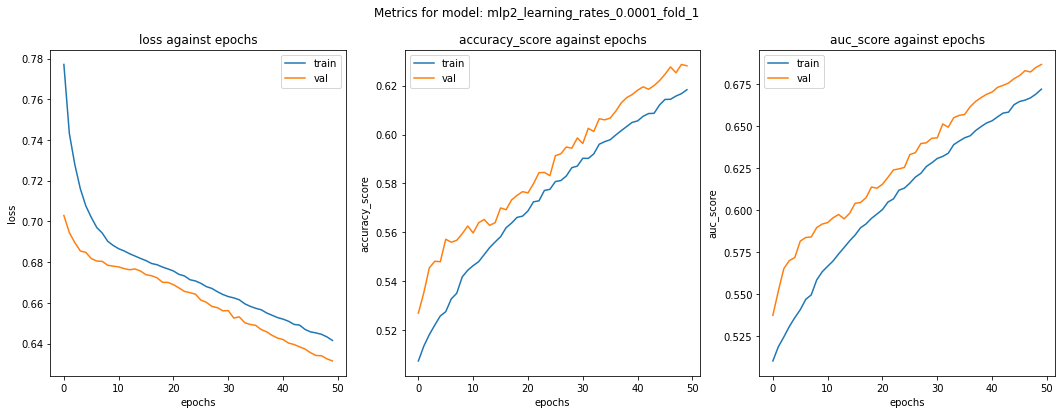

training model fold 2
Epoch 1/50
492/492 [==============================] - 10s 17ms/step - loss: 0.8102 - accuracy: 0.5047 - auc: 0.5077 - val_loss: 0.7035 - val_accuracy: 0.5241 - val_auc: 0.5347
Epoch 2/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7513 - accuracy: 0.5125 - auc: 0.5175 - val_loss: 0.6938 - val_accuracy: 0.5393 - val_auc: 0.5565
Epoch 3/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7335 - accuracy: 0.5146 - auc: 0.5214 - val_loss: 0.6884 - val_accuracy: 0.5456 - val_auc: 0.5647
Epoch 4/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7197 - accuracy: 0.5224 - auc: 0.5303 - val_loss: 0.6850 - val_accuracy: 0.5491 - val_auc: 0.5730
Epoch 5/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7109 - accuracy: 0.5261 - auc: 0.5359 - val_loss: 0.6825 - val_accuracy: 0.5531 - val_auc: 0.5791
Epoch 6/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7046 - accuracy: 0.5266 -

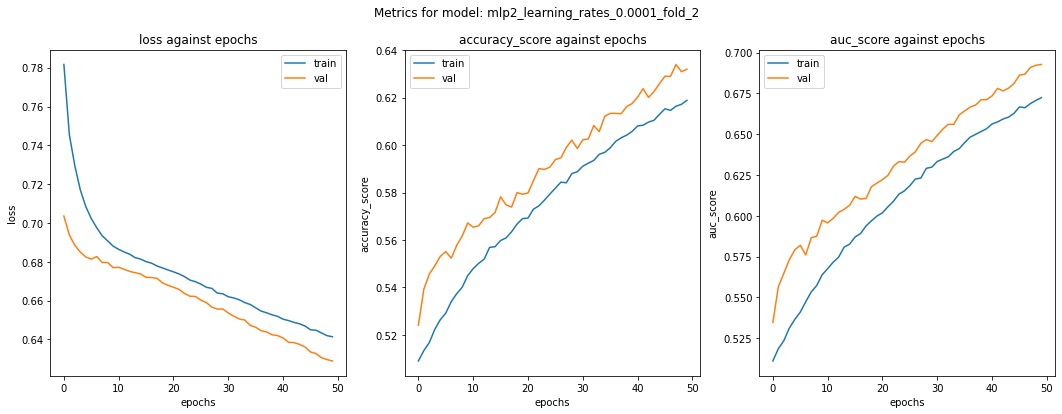

training model fold 3
Epoch 1/50
492/492 [==============================] - 11s 17ms/step - loss: 0.8072 - accuracy: 0.5051 - auc: 0.5070 - val_loss: 0.7036 - val_accuracy: 0.5275 - val_auc: 0.5401
Epoch 2/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7481 - accuracy: 0.5114 - auc: 0.5162 - val_loss: 0.6939 - val_accuracy: 0.5410 - val_auc: 0.5571
Epoch 3/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7310 - accuracy: 0.5149 - auc: 0.5214 - val_loss: 0.6942 - val_accuracy: 0.5351 - val_auc: 0.5557
Epoch 4/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7211 - accuracy: 0.5185 - auc: 0.5273 - val_loss: 0.6853 - val_accuracy: 0.5446 - val_auc: 0.5702
Epoch 5/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7089 - accuracy: 0.5254 - auc: 0.5358 - val_loss: 0.6867 - val_accuracy: 0.5456 - val_auc: 0.5679
Epoch 6/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7043 - accuracy: 0.5267 -

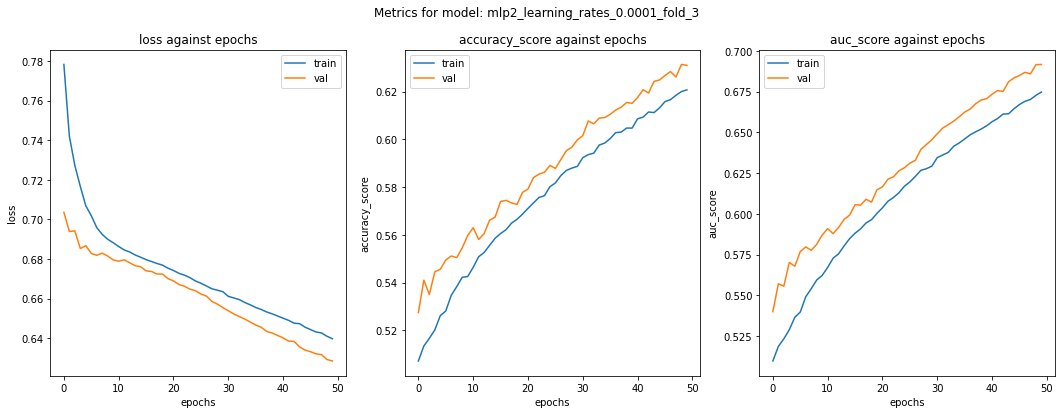

training model fold 4
Epoch 1/50
492/492 [==============================] - 10s 17ms/step - loss: 0.8086 - accuracy: 0.5037 - auc: 0.5065 - val_loss: 0.7013 - val_accuracy: 0.5304 - val_auc: 0.5434
Epoch 2/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7508 - accuracy: 0.5123 - auc: 0.5166 - val_loss: 0.6905 - val_accuracy: 0.5432 - val_auc: 0.5600
Epoch 3/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7350 - accuracy: 0.5167 - auc: 0.5206 - val_loss: 0.6897 - val_accuracy: 0.5467 - val_auc: 0.5649
Epoch 4/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7218 - accuracy: 0.5195 - auc: 0.5258 - val_loss: 0.6879 - val_accuracy: 0.5466 - val_auc: 0.5663
Epoch 5/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7109 - accuracy: 0.5241 - auc: 0.5334 - val_loss: 0.6860 - val_accuracy: 0.5497 - val_auc: 0.5718
Epoch 6/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7043 - accuracy: 0.5281 -

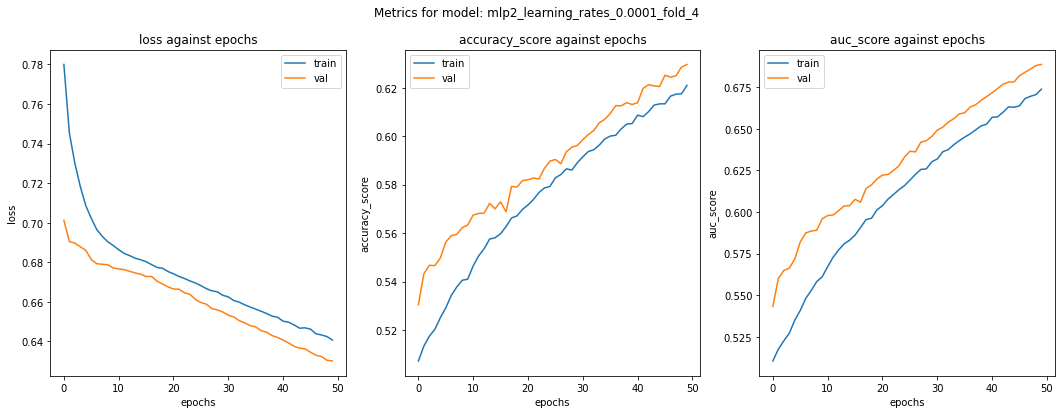

training model fold 5
Epoch 1/50
492/492 [==============================] - 11s 17ms/step - loss: 0.8081 - accuracy: 0.5063 - auc: 0.5081 - val_loss: 0.7064 - val_accuracy: 0.5289 - val_auc: 0.5392
Epoch 2/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7544 - accuracy: 0.5109 - auc: 0.5154 - val_loss: 0.6950 - val_accuracy: 0.5352 - val_auc: 0.5496
Epoch 3/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7352 - accuracy: 0.5140 - auc: 0.5200 - val_loss: 0.6903 - val_accuracy: 0.5422 - val_auc: 0.5580
Epoch 4/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7220 - accuracy: 0.5198 - auc: 0.5272 - val_loss: 0.6946 - val_accuracy: 0.5365 - val_auc: 0.5533
Epoch 5/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7117 - accuracy: 0.5246 - auc: 0.5350 - val_loss: 0.6835 - val_accuracy: 0.5505 - val_auc: 0.5741
Epoch 6/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7049 - accuracy: 0.5264 -

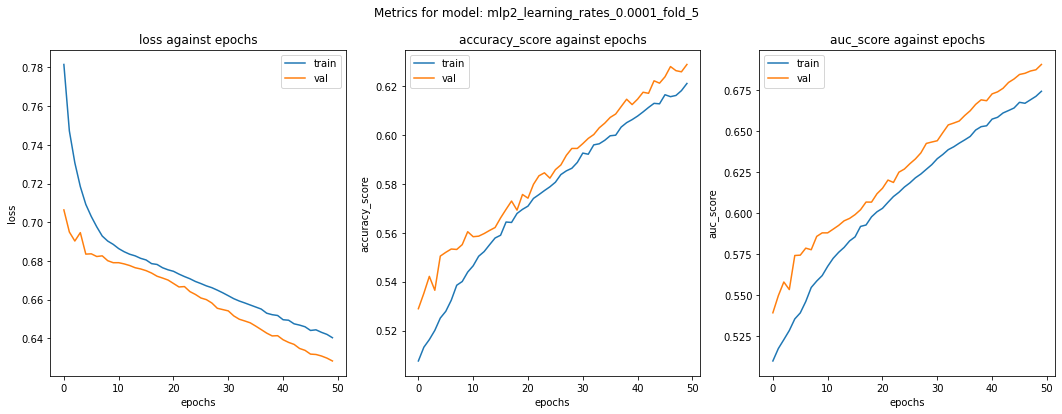

training model fold 6
Epoch 1/50
492/492 [==============================] - 10s 17ms/step - loss: 0.7996 - accuracy: 0.5061 - auc: 0.5077 - val_loss: 0.7012 - val_accuracy: 0.5312 - val_auc: 0.5422
Epoch 2/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7453 - accuracy: 0.5132 - auc: 0.5179 - val_loss: 0.6950 - val_accuracy: 0.5319 - val_auc: 0.5493
Epoch 3/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7289 - accuracy: 0.5178 - auc: 0.5247 - val_loss: 0.6932 - val_accuracy: 0.5411 - val_auc: 0.5611
Epoch 4/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7188 - accuracy: 0.5213 - auc: 0.5288 - val_loss: 0.6875 - val_accuracy: 0.5482 - val_auc: 0.5678
Epoch 5/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7081 - accuracy: 0.5270 - auc: 0.5365 - val_loss: 0.6868 - val_accuracy: 0.5455 - val_auc: 0.5643
Epoch 6/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7026 - accuracy: 0.5274 -

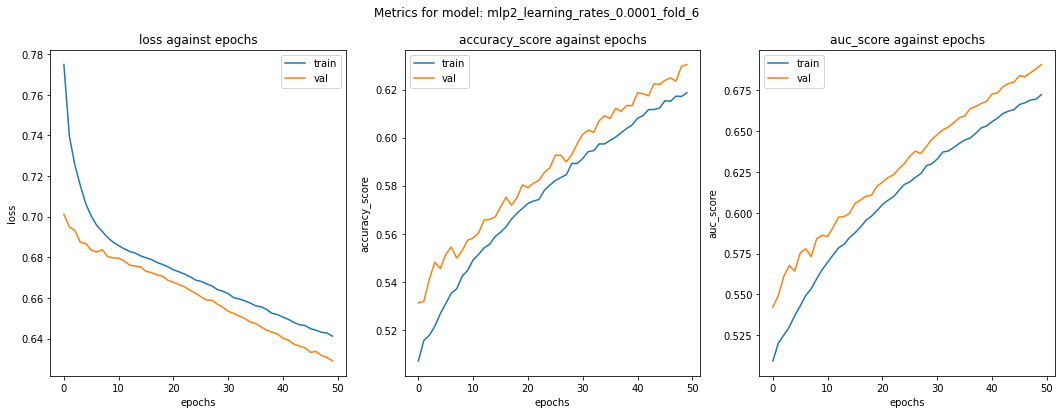

training model fold 7
Epoch 1/50
492/492 [==============================] - 11s 17ms/step - loss: 0.7988 - accuracy: 0.5055 - auc: 0.5067 - val_loss: 0.7072 - val_accuracy: 0.5282 - val_auc: 0.5424
Epoch 2/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7475 - accuracy: 0.5123 - auc: 0.5165 - val_loss: 0.6931 - val_accuracy: 0.5357 - val_auc: 0.5518
Epoch 3/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7296 - accuracy: 0.5162 - auc: 0.5233 - val_loss: 0.6920 - val_accuracy: 0.5357 - val_auc: 0.5520
Epoch 4/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7183 - accuracy: 0.5212 - auc: 0.5284 - val_loss: 0.6890 - val_accuracy: 0.5402 - val_auc: 0.5594
Epoch 5/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7091 - accuracy: 0.5248 - auc: 0.5351 - val_loss: 0.6850 - val_accuracy: 0.5485 - val_auc: 0.5688
Epoch 6/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7020 - accuracy: 0.5301 -

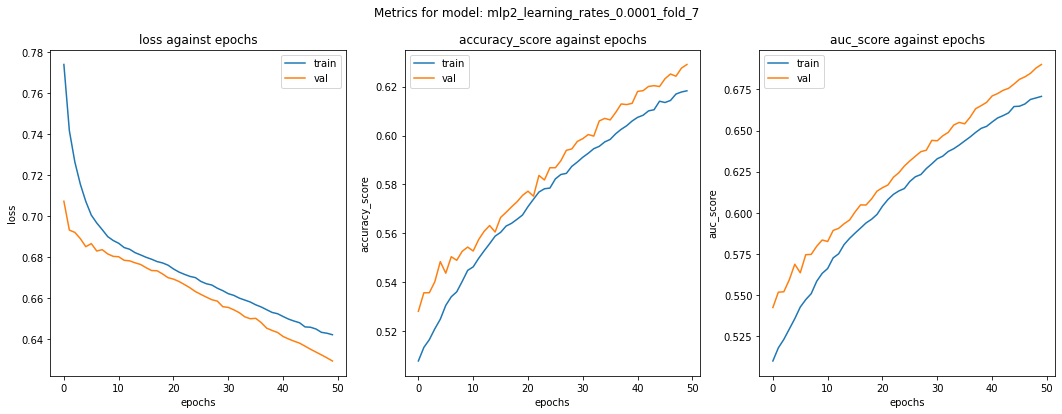

training model fold 8
Epoch 1/50
492/492 [==============================] - 10s 17ms/step - loss: 0.8023 - accuracy: 0.5056 - auc: 0.5075 - val_loss: 0.6977 - val_accuracy: 0.5300 - val_auc: 0.5434
Epoch 2/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7486 - accuracy: 0.5131 - auc: 0.5158 - val_loss: 0.6946 - val_accuracy: 0.5303 - val_auc: 0.5486
Epoch 3/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7314 - accuracy: 0.5165 - auc: 0.5226 - val_loss: 0.6899 - val_accuracy: 0.5391 - val_auc: 0.5577
Epoch 4/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7179 - accuracy: 0.5220 - auc: 0.5306 - val_loss: 0.6864 - val_accuracy: 0.5456 - val_auc: 0.5689
Epoch 5/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7093 - accuracy: 0.5252 - auc: 0.5355 - val_loss: 0.6845 - val_accuracy: 0.5478 - val_auc: 0.5718
Epoch 6/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7035 - accuracy: 0.5286 -

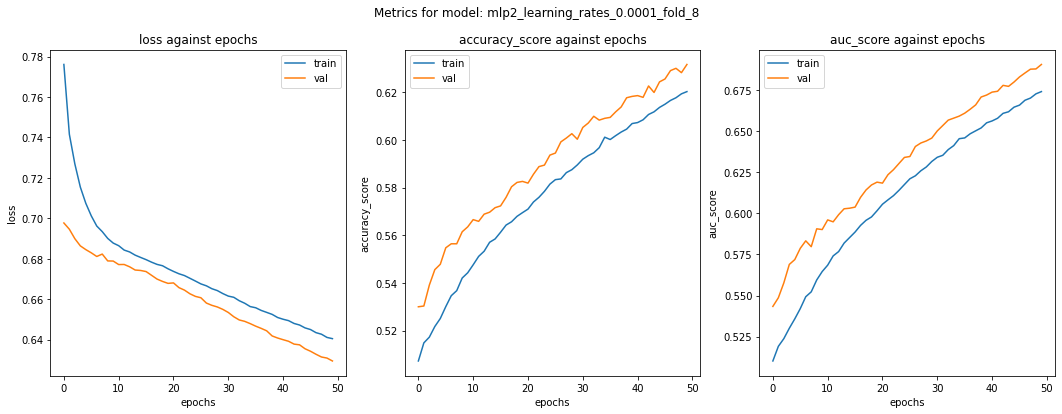

training model fold 9
Epoch 1/50
492/492 [==============================] - 11s 17ms/step - loss: 0.7992 - accuracy: 0.5080 - auc: 0.5112 - val_loss: 0.7014 - val_accuracy: 0.5268 - val_auc: 0.5398
Epoch 2/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7498 - accuracy: 0.5120 - auc: 0.5166 - val_loss: 0.6932 - val_accuracy: 0.5400 - val_auc: 0.5553
Epoch 3/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7311 - accuracy: 0.5178 - auc: 0.5240 - val_loss: 0.6898 - val_accuracy: 0.5400 - val_auc: 0.5601
Epoch 4/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7189 - accuracy: 0.5221 - auc: 0.5302 - val_loss: 0.6881 - val_accuracy: 0.5482 - val_auc: 0.5690
Epoch 5/50
492/492 [==============================] - 8s 17ms/step - loss: 0.7084 - accuracy: 0.5275 - auc: 0.5377 - val_loss: 0.6848 - val_accuracy: 0.5515 - val_auc: 0.5736
Epoch 6/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7035 - accuracy: 0.5302 -

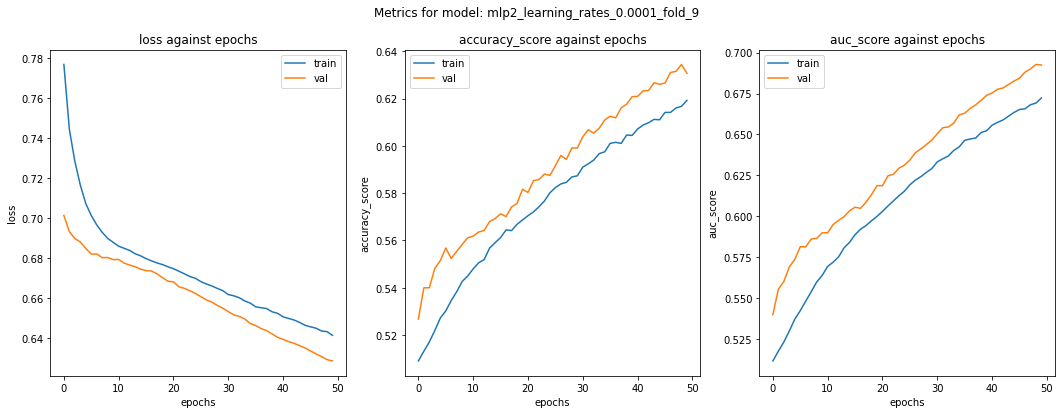

training model fold 10
Epoch 1/50
492/492 [==============================] - 10s 17ms/step - loss: 0.7971 - accuracy: 0.5033 - auc: 0.5051 - val_loss: 0.7041 - val_accuracy: 0.5278 - val_auc: 0.5354
Epoch 2/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7424 - accuracy: 0.5134 - auc: 0.5176 - val_loss: 0.6945 - val_accuracy: 0.5350 - val_auc: 0.5511
Epoch 3/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7269 - accuracy: 0.5169 - auc: 0.5226 - val_loss: 0.6891 - val_accuracy: 0.5445 - val_auc: 0.5608
Epoch 4/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7161 - accuracy: 0.5206 - auc: 0.5281 - val_loss: 0.6886 - val_accuracy: 0.5418 - val_auc: 0.5621
Epoch 5/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7077 - accuracy: 0.5241 - auc: 0.5333 - val_loss: 0.6854 - val_accuracy: 0.5467 - val_auc: 0.5688
Epoch 6/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7013 - accuracy: 0.5283 

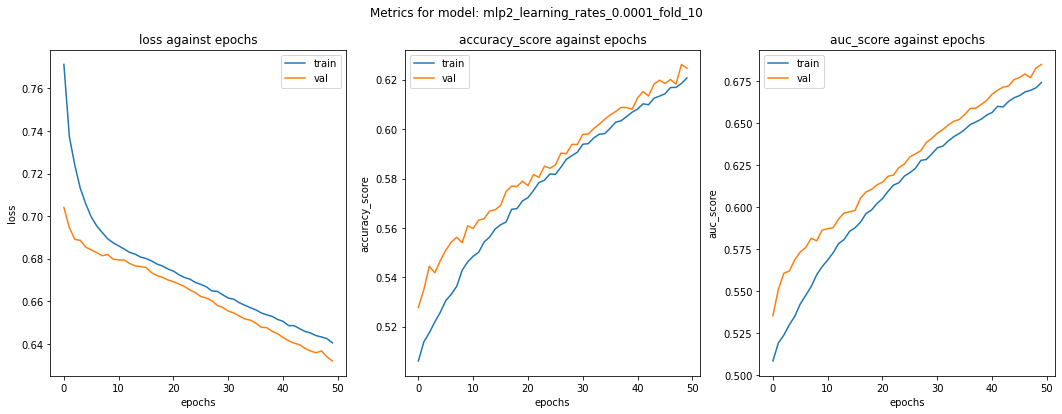

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [1426.5168512740488, 0.6296293699651482, 0.6292167200198936, 9245.7, 8341.8, 5338.4, 5007.2]
saved model metrics

model_name:  mlp2_learning_rates_1e-06
model_params:  batch_size=512, hidden_unit=[200, 400, 800, 400], activation=<function tanh at 0x7fc3beb8e680>, dropout_rate=[0.2, 0.2, 0.2, 0.2], learning_rate=1e-06, epoch=50
training model fold 1
Epoch 1/50
492/492 [==============================] - 11s 17ms/step - loss: 0.8828 - accuracy: 0.4993 - auc: 0.4997 - val_loss: 0.7290 - val_accuracy: 0.5030 - val_auc: 0.5065
Epoch 2/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8402 - accuracy: 0.5035 - auc: 0.5051 - val_loss: 0.7156 - val_accuracy: 0.5129 - val_auc: 0.5176
Epoch 3/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8275 - accuracy: 0.5029 - auc: 0.5049 - val_loss: 0.7104 - val_accuracy: 0.5163 - val_auc: 0.5218
Epoch 4/50
492/49

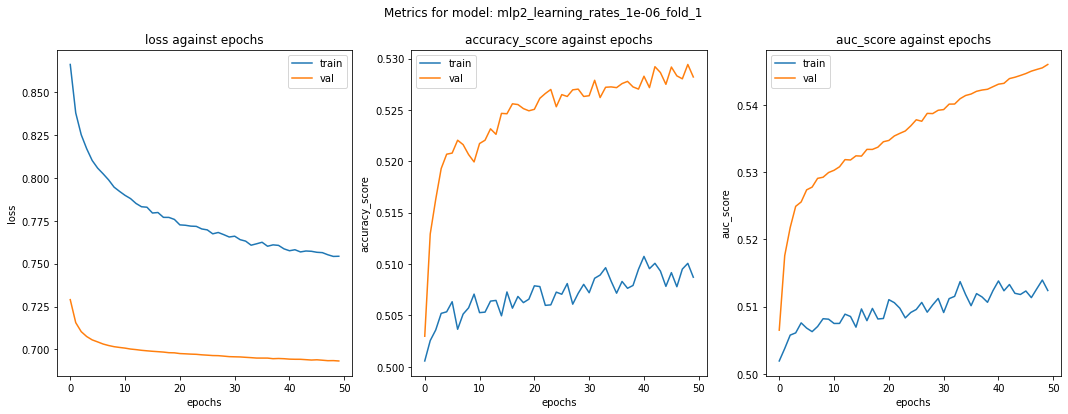

training model fold 2
Epoch 1/50
492/492 [==============================] - 11s 19ms/step - loss: 0.9014 - accuracy: 0.5021 - auc: 0.5017 - val_loss: 0.7337 - val_accuracy: 0.5094 - val_auc: 0.5120
Epoch 2/50
492/492 [==============================] - 9s 17ms/step - loss: 0.8577 - accuracy: 0.4980 - auc: 0.4991 - val_loss: 0.7224 - val_accuracy: 0.5087 - val_auc: 0.5127
Epoch 3/50
492/492 [==============================] - 9s 17ms/step - loss: 0.8398 - accuracy: 0.5011 - auc: 0.5030 - val_loss: 0.7165 - val_accuracy: 0.5104 - val_auc: 0.5144
Epoch 4/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8293 - accuracy: 0.5031 - auc: 0.5040 - val_loss: 0.7132 - val_accuracy: 0.5116 - val_auc: 0.5156
Epoch 5/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8206 - accuracy: 0.5042 - auc: 0.5054 - val_loss: 0.7111 - val_accuracy: 0.5113 - val_auc: 0.5163
Epoch 6/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8132 - accuracy: 0.5067 -

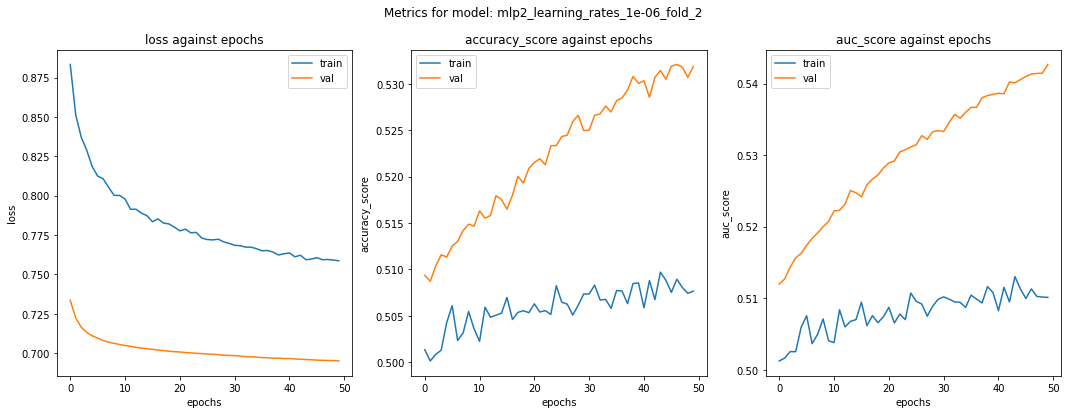

training model fold 3
Epoch 1/50
492/492 [==============================] - 11s 19ms/step - loss: 0.9128 - accuracy: 0.4984 - auc: 0.4982 - val_loss: 0.7391 - val_accuracy: 0.4970 - val_auc: 0.4972
Epoch 2/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8657 - accuracy: 0.5027 - auc: 0.5030 - val_loss: 0.7259 - val_accuracy: 0.5006 - val_auc: 0.5046
Epoch 3/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8514 - accuracy: 0.5012 - auc: 0.5017 - val_loss: 0.7202 - val_accuracy: 0.5069 - val_auc: 0.5100
Epoch 4/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8416 - accuracy: 0.5024 - auc: 0.5027 - val_loss: 0.7163 - val_accuracy: 0.5088 - val_auc: 0.5127
Epoch 5/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8324 - accuracy: 0.5055 - auc: 0.5058 - val_loss: 0.7136 - val_accuracy: 0.5110 - val_auc: 0.5147
Epoch 6/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8255 - accuracy: 0.5025 -

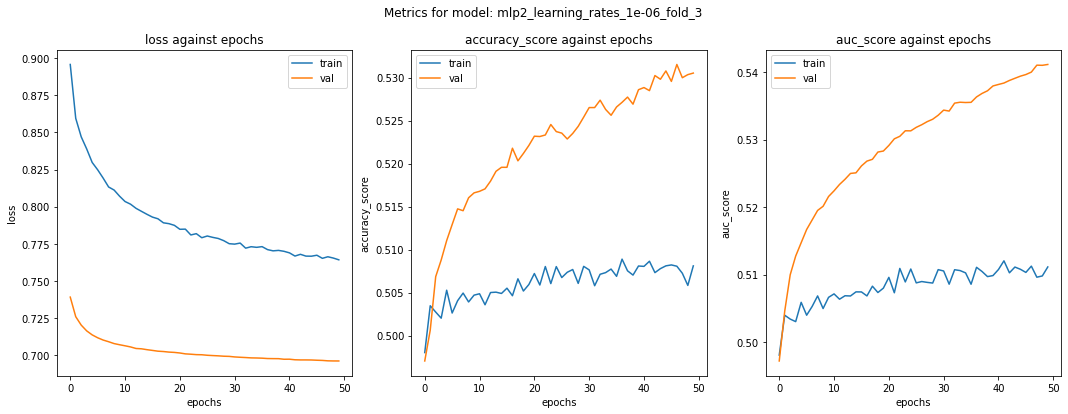

training model fold 4
Epoch 1/50
492/492 [==============================] - 11s 19ms/step - loss: 0.8985 - accuracy: 0.5006 - auc: 0.4985 - val_loss: 0.7382 - val_accuracy: 0.5044 - val_auc: 0.5064
Epoch 2/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8524 - accuracy: 0.5018 - auc: 0.5027 - val_loss: 0.7260 - val_accuracy: 0.5076 - val_auc: 0.5117
Epoch 3/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8383 - accuracy: 0.5029 - auc: 0.5038 - val_loss: 0.7202 - val_accuracy: 0.5098 - val_auc: 0.5148
Epoch 4/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8281 - accuracy: 0.5042 - auc: 0.5053 - val_loss: 0.7162 - val_accuracy: 0.5106 - val_auc: 0.5165
Epoch 5/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8207 - accuracy: 0.5031 - auc: 0.5047 - val_loss: 0.7137 - val_accuracy: 0.5132 - val_auc: 0.5182
Epoch 6/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8179 - accuracy: 0.5024 -

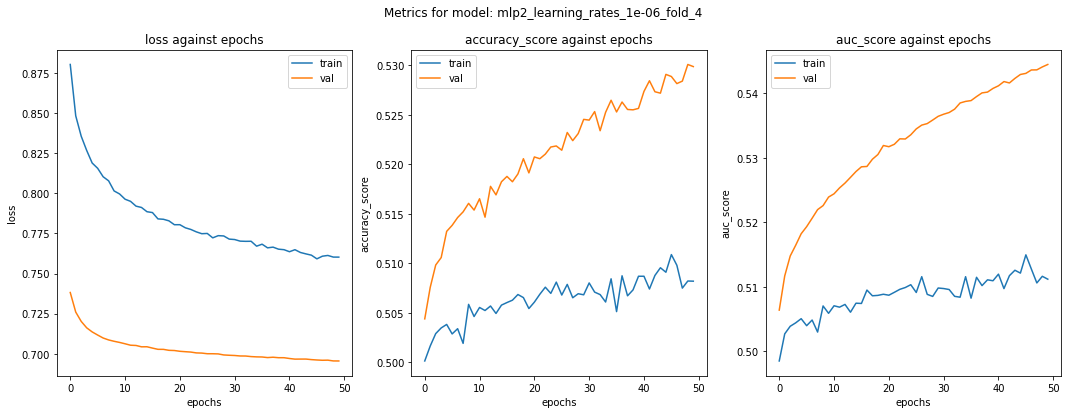

training model fold 5
Epoch 1/50
492/492 [==============================] - 12s 19ms/step - loss: 0.8909 - accuracy: 0.5035 - auc: 0.5050 - val_loss: 0.7315 - val_accuracy: 0.5098 - val_auc: 0.5116
Epoch 2/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8482 - accuracy: 0.5026 - auc: 0.5044 - val_loss: 0.7205 - val_accuracy: 0.5095 - val_auc: 0.5123
Epoch 3/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8380 - accuracy: 0.5017 - auc: 0.5030 - val_loss: 0.7161 - val_accuracy: 0.5090 - val_auc: 0.5138
Epoch 4/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8293 - accuracy: 0.5024 - auc: 0.5029 - val_loss: 0.7136 - val_accuracy: 0.5100 - val_auc: 0.5152
Epoch 5/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8189 - accuracy: 0.5053 - auc: 0.5063 - val_loss: 0.7119 - val_accuracy: 0.5125 - val_auc: 0.5165
Epoch 6/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8175 - accuracy: 0.5030 -

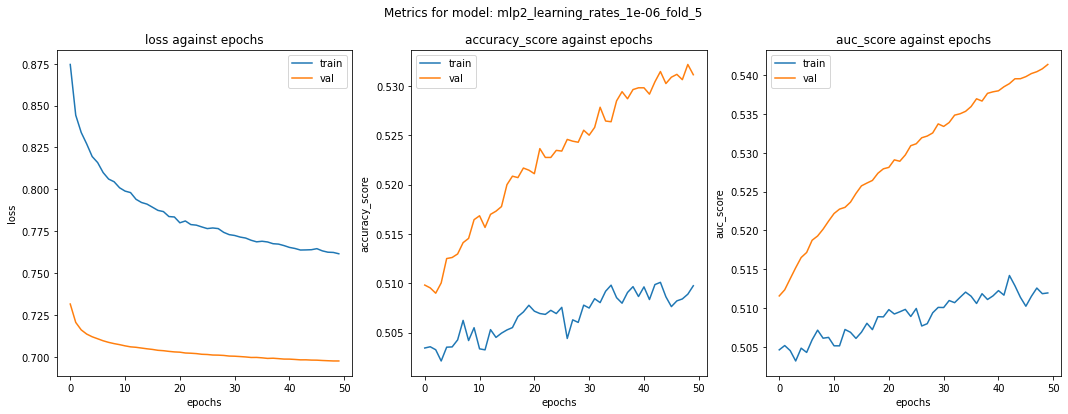

training model fold 6
Epoch 1/50
492/492 [==============================] - 11s 19ms/step - loss: 0.8985 - accuracy: 0.5001 - auc: 0.4989 - val_loss: 0.7340 - val_accuracy: 0.5040 - val_auc: 0.5070
Epoch 2/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8531 - accuracy: 0.5006 - auc: 0.5000 - val_loss: 0.7213 - val_accuracy: 0.5102 - val_auc: 0.5125
Epoch 3/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8394 - accuracy: 0.5003 - auc: 0.5001 - val_loss: 0.7155 - val_accuracy: 0.5121 - val_auc: 0.5161
Epoch 4/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8277 - accuracy: 0.5030 - auc: 0.5036 - val_loss: 0.7118 - val_accuracy: 0.5137 - val_auc: 0.5190
Epoch 5/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8211 - accuracy: 0.5038 - auc: 0.5036 - val_loss: 0.7094 - val_accuracy: 0.5143 - val_auc: 0.5213
Epoch 6/50
492/492 [==============================] - 9s 17ms/step - loss: 0.8136 - accuracy: 0.5049 -

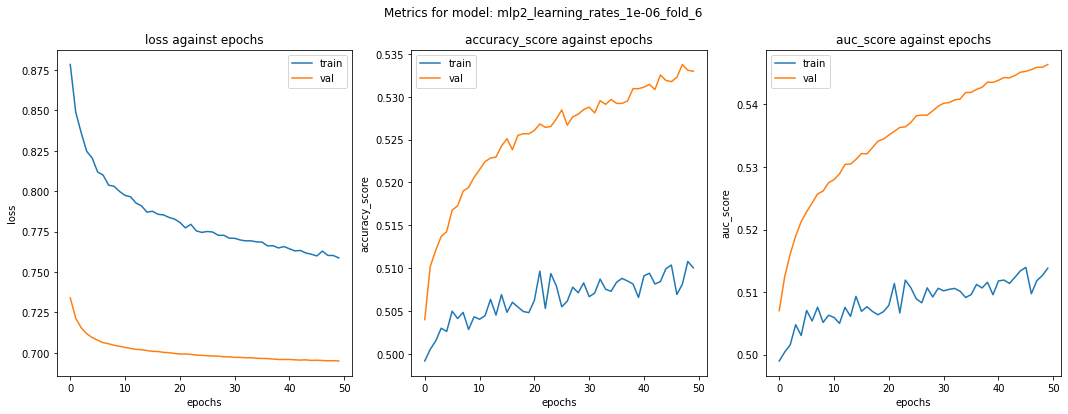

training model fold 7
Epoch 1/50
492/492 [==============================] - 12s 19ms/step - loss: 0.9088 - accuracy: 0.5023 - auc: 0.5039 - val_loss: 0.7343 - val_accuracy: 0.5063 - val_auc: 0.5091
Epoch 2/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8527 - accuracy: 0.5047 - auc: 0.5063 - val_loss: 0.7225 - val_accuracy: 0.5097 - val_auc: 0.5146
Epoch 3/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8418 - accuracy: 0.5055 - auc: 0.5054 - val_loss: 0.7175 - val_accuracy: 0.5098 - val_auc: 0.5165
Epoch 4/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8331 - accuracy: 0.5033 - auc: 0.5042 - val_loss: 0.7148 - val_accuracy: 0.5140 - val_auc: 0.5186
Epoch 5/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8209 - accuracy: 0.5085 - auc: 0.5098 - val_loss: 0.7121 - val_accuracy: 0.5138 - val_auc: 0.5192
Epoch 6/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8185 - accuracy: 0.5044 -

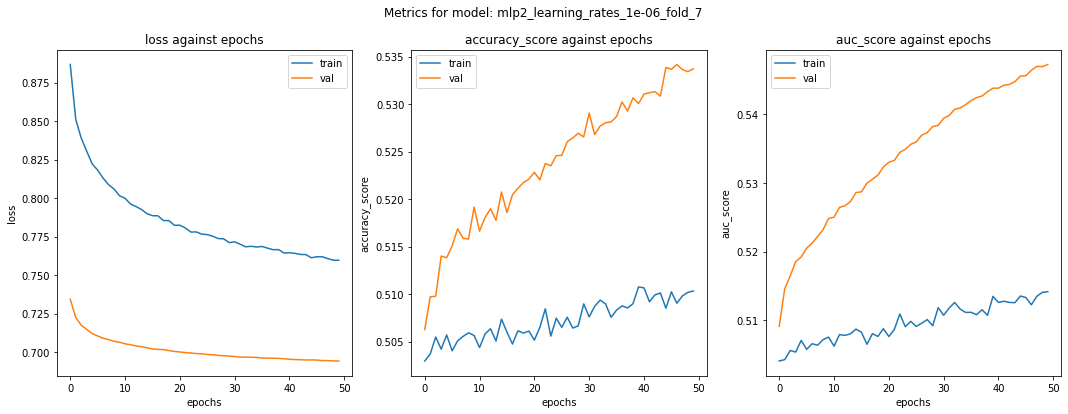

training model fold 8
Epoch 1/50
492/492 [==============================] - 11s 19ms/step - loss: 0.9367 - accuracy: 0.4992 - auc: 0.5000 - val_loss: 0.7386 - val_accuracy: 0.4994 - val_auc: 0.5010
Epoch 2/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8602 - accuracy: 0.5010 - auc: 0.5028 - val_loss: 0.7256 - val_accuracy: 0.5041 - val_auc: 0.5062
Epoch 3/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8470 - accuracy: 0.5023 - auc: 0.5033 - val_loss: 0.7198 - val_accuracy: 0.5085 - val_auc: 0.5094
Epoch 4/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8304 - accuracy: 0.5062 - auc: 0.5094 - val_loss: 0.7163 - val_accuracy: 0.5089 - val_auc: 0.5114
Epoch 5/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8292 - accuracy: 0.5030 - auc: 0.5047 - val_loss: 0.7138 - val_accuracy: 0.5089 - val_auc: 0.5127
Epoch 6/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8229 - accuracy: 0.5039 -

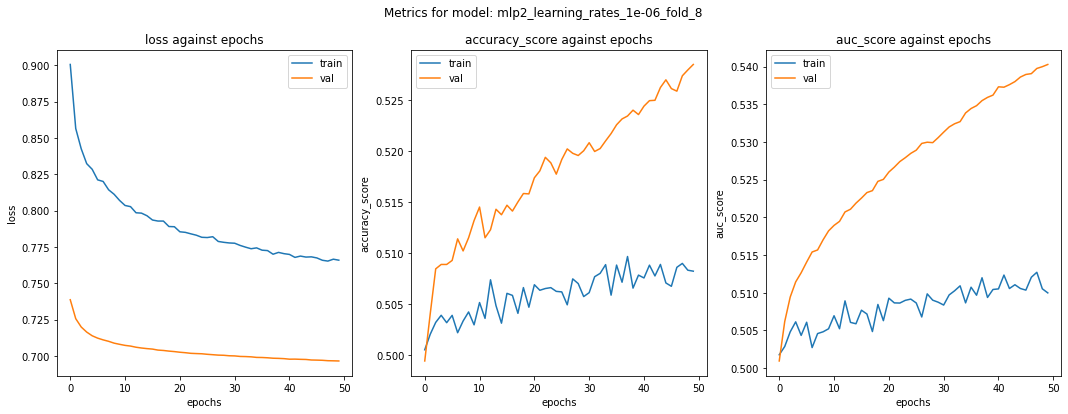

training model fold 9
Epoch 1/50
492/492 [==============================] - 12s 19ms/step - loss: 0.8929 - accuracy: 0.5005 - auc: 0.5007 - val_loss: 0.7373 - val_accuracy: 0.5017 - val_auc: 0.5050
Epoch 2/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8502 - accuracy: 0.5004 - auc: 0.5024 - val_loss: 0.7241 - val_accuracy: 0.5048 - val_auc: 0.5079
Epoch 3/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8338 - accuracy: 0.5034 - auc: 0.5051 - val_loss: 0.7189 - val_accuracy: 0.5052 - val_auc: 0.5097
Epoch 4/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8266 - accuracy: 0.5026 - auc: 0.5053 - val_loss: 0.7158 - val_accuracy: 0.5067 - val_auc: 0.5113
Epoch 5/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8210 - accuracy: 0.5015 - auc: 0.5022 - val_loss: 0.7135 - val_accuracy: 0.5077 - val_auc: 0.5133
Epoch 6/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8130 - accuracy: 0.5045 -

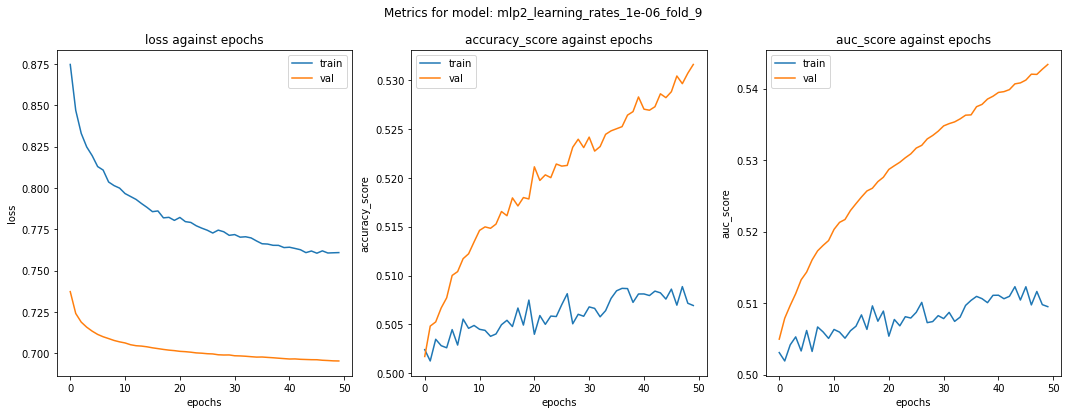

training model fold 10
Epoch 1/50
492/492 [==============================] - 11s 19ms/step - loss: 0.9373 - accuracy: 0.4991 - auc: 0.4981 - val_loss: 0.7396 - val_accuracy: 0.5027 - val_auc: 0.5059
Epoch 2/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8599 - accuracy: 0.5005 - auc: 0.5021 - val_loss: 0.7268 - val_accuracy: 0.5060 - val_auc: 0.5109
Epoch 3/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8415 - accuracy: 0.5021 - auc: 0.5057 - val_loss: 0.7204 - val_accuracy: 0.5101 - val_auc: 0.5147
Epoch 4/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8331 - accuracy: 0.5028 - auc: 0.5046 - val_loss: 0.7167 - val_accuracy: 0.5113 - val_auc: 0.5163
Epoch 5/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8219 - accuracy: 0.5055 - auc: 0.5079 - val_loss: 0.7139 - val_accuracy: 0.5121 - val_auc: 0.5175
Epoch 6/50
492/492 [==============================] - 9s 18ms/step - loss: 0.8183 - accuracy: 0.5045 

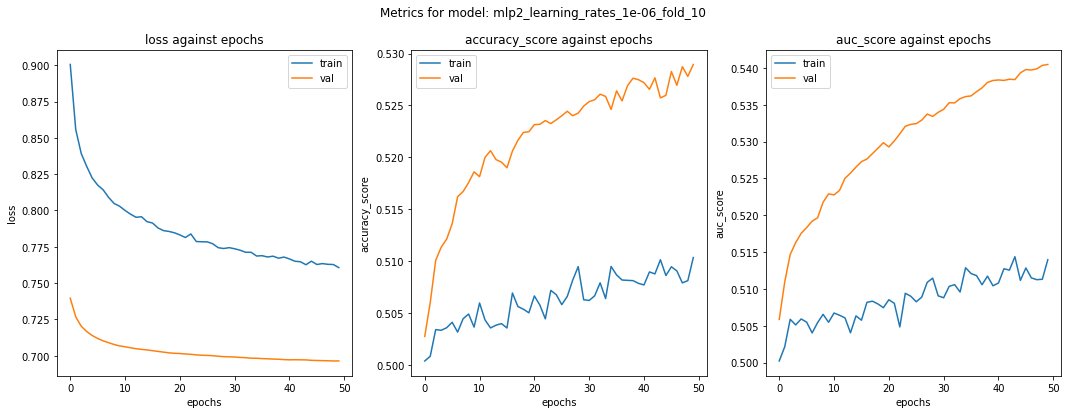

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [133.6856015424308, 0.5307359459802006, 0.5299114829976295, 8117.7, 6707.4, 6972.8, 6135.2]
saved model metrics


In [16]:
for batch_size in batch_sizes:
  for hidden_unit in hidden_units:
    for activation in activations:
      for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
          for epoch in epochs:

            output_filename = "CV_SCORES_AVE_NNDL.csv"
            workbook_name = "12F_nndl_cv_mlp2_learning_rates"
            model_name = f"mlp2_learning_rates_{learning_rate}"
            model_params = f"batch_size={batch_size}, hidden_unit={hidden_unit}, activation={activation}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, epoch={epoch}"
                    
            print("")
            print("model_name: ", model_name)
            print("model_params: ", model_params)

            # cross validation
            cv_scores = []

            for i, (train_idx, val_idx) in enumerate(kf.split(x_train)):
              # train-val data (for utility score calculation) 
              train_cv, val_cv = train.iloc[train_idx], train.iloc[val_idx]
              # train-val features 
              x_train_cv, x_val_cv, y_train_cv, y_val_cv = x_train[train_idx], x_train[val_idx], y_train[train_idx], y_train[val_idx]

              # scaling data to make it easier for models to train
              scaler = StandardScaler().fit(x_train_cv)
              x_train_cv = scaler.transform(x_train_cv)

              # test set scaled on the same scaler as train, because models are fitted on the train distributions and not test distributions
              x_val_cv = scaler.transform(x_val_cv)

              print(f"training model fold {i+1}")

              model = create_mlp(x_train_cv.shape[1], hidden_unit, activation, dropout_rate, learning_rate)
              model_name_fold = model_name + f"_fold_{i+1}"
              # CheckpointCallback = ModelCheckpoint(str(PATH_CHECKPOINTS / (model_name + '.hdf5')), monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='auto', save_freq='epoch')

              history = model.fit(
                  x_train_cv, 
                  y_train_cv, 
                  epochs=epoch, 
                  batch_size=batch_size,
                  validation_data=(x_val_cv, y_val_cv),
                  # callbacks = [CheckpointCallback]
              )

              model_score = model_scores(model, test=val_cv, x_test=x_val_cv, y_test=y_val_cv)
              cv_scores.append(model_score)

              history_saver(history, model_name_fold, PATH_HISTORIES, already_npy=False)
              history = history_loader(model_name_fold, PATH_HISTORIES)
              plot_metrics(history, model_name_fold, PATH_FIGURES)

            # mean of cv scores
            cv_scores_ave = [sum(ele) / len(cv_scores) for ele in zip(*cv_scores)]
            print("cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg")
            print("cv_scores_ave: ", cv_scores_ave)

            # save average scores
            save_scores(output_filename, workbook_name, model_name, model_params, *cv_scores_ave)


In [17]:
# '''
# predict on the test set. load best weights from checkpoints
# '''
# # model.load_weights(str(PATH_CHECKPOINTS / (model_name + '.hdf5')))

# test_metrics = model.evaluate(x_test, steps=3)

# test_metrics_dict = {
#     'test_loss': test_metrics[0]
# }

# np.save(PATH_PREDICTIONS/str(model_name + "_prediction_score"), test_metrics_dict)

In [18]:
# y_pred = (model.predict(x_test) > 0.5).astype(int)
# utility_score(test, y_pred)

# Conclusion